# K Vector

This notebook contains notes about the measurements in the laboratory to determine the parameters to adjust the boresight with the rotation of the K mirror.

In [12]:
from fifipy.fit import computeSpectra
from fifipy.calib import computeAllWaves
from fifipy.io import saveSlopeFits, readData
from glob import glob as gb
from astropy.io import fits
import os
import re
import numpy as np

path = '/home/dario/Python/Fifilab/KVectorData/KD105/200810_001/fits/'
channel = 'sw'
filenames = '*KV*_'+channel+'.fits'
files = sorted(gb(os.path.join(path, filenames)))
    
    
gpos, specs = computeSpectra(files, telSim=True)
aor, hk, gratpos, flux = readData(files[0])
obsdate,telpos,pos,xy,an,za,alti,wv = hk
detchan, order, dichroic, ncycles, nodbeam, filegpid, filenum = aor
wave, dwave = computeAllWaves(gpos, dichroic, obsdate, detchan, order)
xcoords = []
ycoords = []
match1 = r"(-?\d,-?\d)"
match2 = r"(\d)x"
for f in files:
    x1 = re.search(match1, f)
    coords = x1.group(1)
    xcoord, ycoord = coords.split(',')
    x2 = re.search(match2, f)
    factor = int(x2.group(1))
    xcoords.append(int(xcoord)*factor)
    ycoords.append(int(ycoord)*factor)
xcoords = np.array(xcoords)
ycoords = np.array(ycoords)

header = fits.getheader(files[0])
kmirrpos = header['KMIRRPOS']
channel = header['DETCHAN']
dichroic = header['DICHROIC']
if channel == 'BLUE':
    isu = header['G_STRT_B']
    ch = 'B'
    order = header['G_ORD_B']
else:
    isu = header['G_STRT_R']
    ch = 'R'
    order = 1
path = '/home/dario/Python/Fifilab/KVectorData/Reduced/'
#outname = os.path.join(path,'KV_'+ch+str(order)+'_D'+str(dichroic)+'_K'+str(kmirrpos)+'_G'+str(isu)+'.fits')
saveSlopeFits(gpos, dichroic, obsdate, detchan, order, specs, wave, dwave, path+'test.fits',
              xcoords=xcoords, ycoords=ycoords, kmirr=kmirrpos, gratpos=isu)

0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........10.........11.........12.........13.........14.........15.........16.........17.........18.........19.........20.........21.........22.........23.........24.........25.........26.........27.........28........

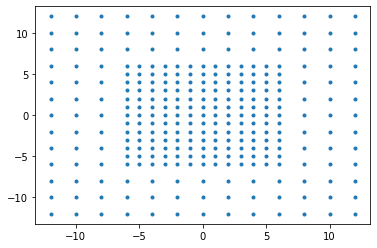

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(xcoords, ycoords,'.')
plt.show()

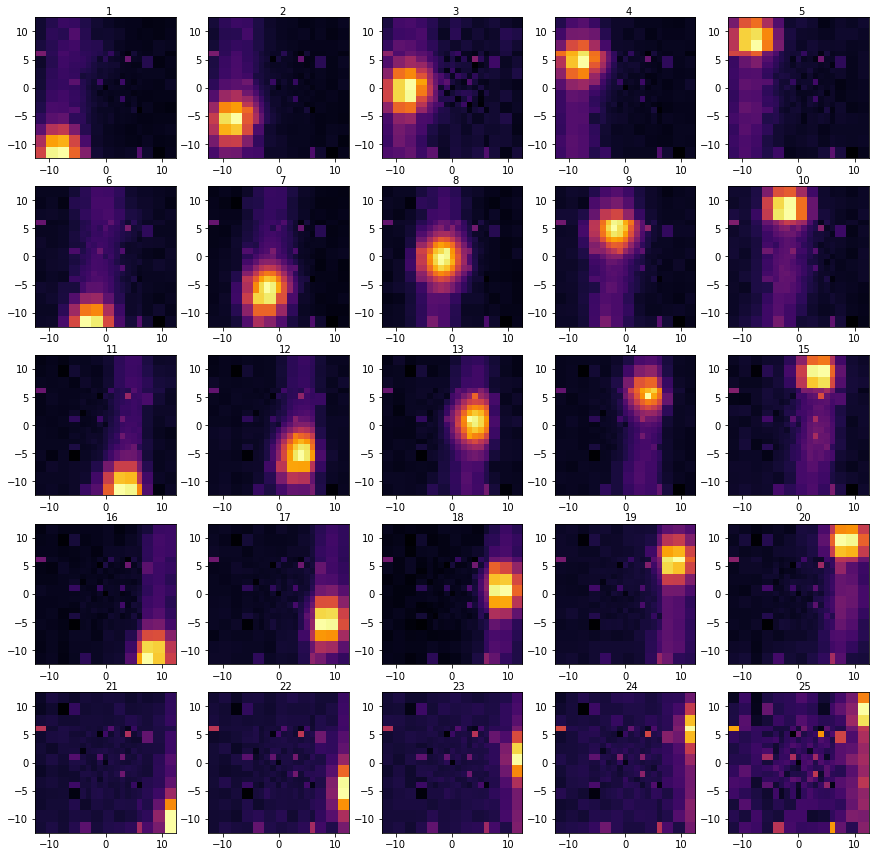

In [1]:
%matplotlib inline
from fifipy.kvector import plotPixels
infile = '/home/dario/Python/Fifilab/KVectorData/Reduced/R1_D105_K1092_G1003000.fits'
plotPixels(infile)


In [ ]:
# Routine to fit the positions with 2D Gaussian after subtraction of vertical 

# K mirror position - approximate relationship

The K mirror position is conserved in the keyword: KMIRRPOS.
Apparently the relationship with angles in degrees is:

$ \alpha^o = (\mbox{KMIRRPOS} - 52) \times 0.0871 $


In [105]:
p0 = 52
delta = 0.0871
for kmirrpos in [1092,2124,3156]:
    print(kmirrpos, (kmirrpos-p0)*delta)

1092 90.584
2124 180.47119999999998
3156 270.3584


# General routines 

## Data reduction

Data in a calibration run are reduced and conserved in a directory.

In [2]:
# Data reduction
from fifipy.kvector import reduceKVdata
rootdir = '/home/dario/Python/Fifilab/KVectorData/'
reduceKVdata(rootdir, names=['01'])


 /home/dario/Python/Fifilab/KVectorData/**/*KV01*sw.fits :  289
0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........10.........11.........12.........13.........14.........15.........16.........17.........18.........19.........20.........21.........22.........23.........24.........25.........26.........27.........28........shape specs  (289, 16, 25)

 /home/dario/Python/Fifilab/KVectorData/**/*KV01*lw.fits :  289
0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........10.........11.........12.........13.........14.........15.........16.........17.........18.........19.........20.........21.........22.........23.........24.........25.........26.........27.........28........shape specs  (289, 16, 25)


## Collapse along spectral direction

Each 16 spectral pixels are collapsed with a biweight median.
The resulting products are arrays with dimensions:

$[14, 25, 19\times19]$

with 2 K-mirror x 7 different grating positions, 25 spaxels, 19$\times$19 sources positions.



In [4]:
from glob import glob as gb
import os
import numpy as np
from fifipy.stats import biweightLocation
from fifipy.kvector import readKVfile, saveKVfile

rootdir = '/home/dario/Python/Fifilab/KVectorData/Reduced/'
channel = 'B'
dichroic = '105'
filenames = channel+'*_D'+dichroic+'_K*.fits'
matchfile = os.path.join(rootdir, '**', filenames)
files = gb(matchfile, recursive=True)
nfiles = len(files)
if nfiles > 0:
    print(filenames, nfiles)
    # Order files by Kmirror and Grating position
    files = np.array(files)
    kmirr = np.array([file.split('_')[2][1:] for file in files])
    gpos = np.array([file.split('_')[3][1:-5] for file in files])
    s1 = np.argsort(gpos)
    files = files[s1]
    kmirr = kmirr[s1]
    gpos = gpos[s1]
    s2 = np.argsort(kmirr)
    files = files[s2]
    kmirr = kmirr[s2]
    gpos = gpos[s2]
    fluxes = np.zeros((nfiles, 25, 289))
    # Open files and collapse along spectral direction
    for flux, file in zip(fluxes, files):
        xcoords, ycoords, specs = readKVfile(file)
        med = biweightLocation(specs, axis=1)
        for k in range(25):
            flux[k] = med[:,k]
    # Save new files
    print(np.shape(fluxes))

B*_D105_K*.fits 14
(14, 25, 289)


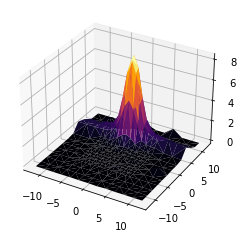

<ipython-input-13-50f8616cbaec>:9: UserWarning: linewidths is ignored by contourf
  ax.tricontourf(xcoords, ycoords, fluxes[2,2,:], cmap='inferno',levels=14, linewidths=0.5)


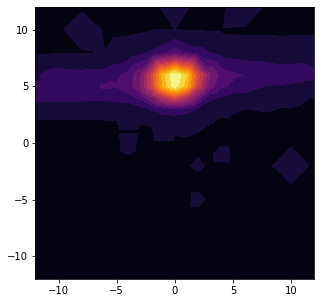

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')
ax.plot_trisurf(xcoords, ycoords, fluxes[2,2,:], cmap='inferno', edgecolor='none');
plt.show()

fig,ax = plt.subplots(figsize=(5,5))
ax.tricontourf(xcoords, ycoords, fluxes[2,2,:], cmap='inferno',levels=14, linewidths=0.5)

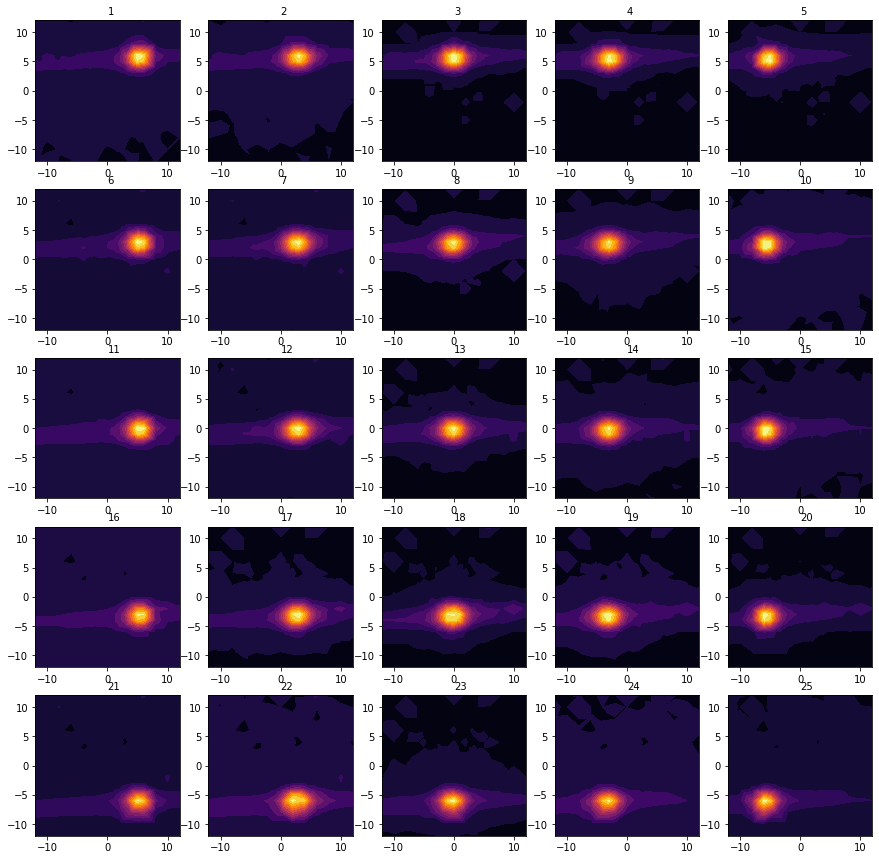

In [1]:
%matplotlib inline
from fifipy.kvector import plot2D
infile = '/home/dario/Python/Fifilab/KVectorData/Reduced/B1_D105_K1092_G180000.fits'
plot2D(infile)

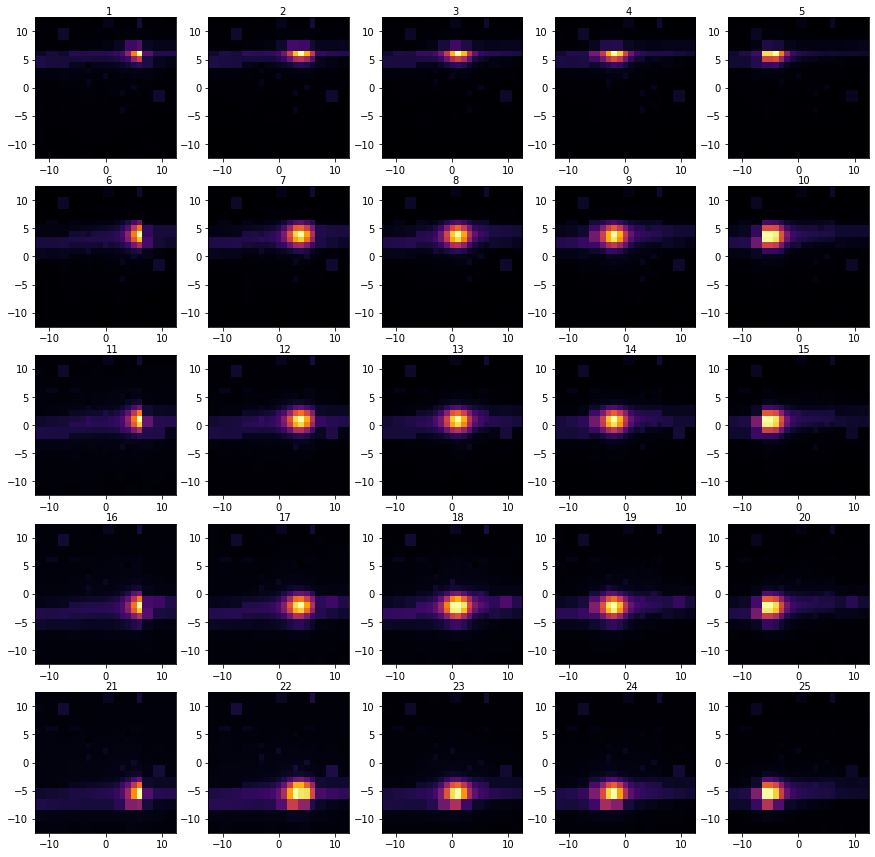

In [2]:
from fifipy.kvector import plotPixels
plotPixels(infile)

In [1]:
from fifipy.kvector import collapseCubes
rootdir = '/home/dario/Python/Fifilab/KVectorData/'
collapseCubes(rootdir)

B*_D105_K*.fits 14
R*_D105_K*.fits 14


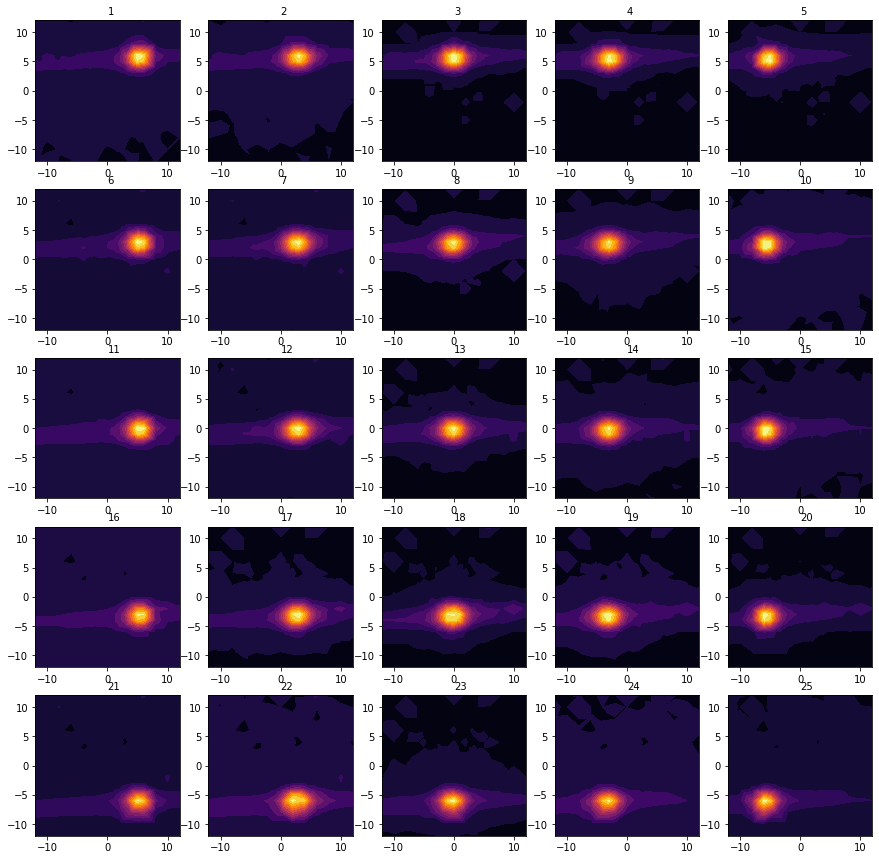

In [5]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
rootdir = '/home/dario/Python/Fifilab/KVectorData/'
with fits.open(rootdir + 'B_105.fits') as hdul:
    xcoords = hdul['XCOORDS'].data
    ycoords = hdul['YCOORDS'].data
    fluxes = hdul['FLUXES'].data
    
fig,axes =plt.subplots(5,5,figsize=(15,15))
for npix in range(25):
    ax = axes[npix // 5 , npix % 5]
    ax.tricontourf(xcoords, ycoords, fluxes[0,npix,:], cmap='inferno',levels=14)
    ax.text(0,13,str(npix+1),color='black')
plt.show()

# Fitting

We have xcoords, ycoords, flux.
We have to fit a 2D Gaussian, eventually with a band 1D Gaussian across the image.


In [5]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
rootdir = '/home/dario/Python/Fifilab/KVectorData/'
with fits.open(rootdir + 'B_105.fits') as hdul:
    xcoords = hdul['XCOORDS'].data
    ycoords = hdul['YCOORDS'].data
    fluxes = hdul['FLUXES'].data
    waves = hdul['WAVES'].data
    orders = hdul['ORDERS'].data

npix = 18 # central spaxel
flux = fluxes[0,npix,:]

# Find optimal 2D gaussian fitting the data
from lmfit import Parameters, minimize
from fifipy.kvector import getPSFsigma
def residuals2Dgauss(p, x, y, data=None):
    import numpy as np
    v = p.valuesdict()
    x0 = v['x0']
    y0 = v['y0']
    sx = v['sx']
    sy = v['sy']
    A  = v['A']
    x_ = (x-x0)/sx
    y_ = (y-y0)/sy
    model = A / (2 *np.pi * sx * sy) * np.exp(-0.5 * (x_**2 +y_**2) )
    if data is None:
        return model
    else:
        return model-data
    
scale = 3.55 # arcsec/mm
step = 3 #mm
sigma = getPSFsigma('B', orders[0], waves[0])  # Blue   
amplitude = np.nanmax(flux) - np.nanmedian(flux)
sigma /= scale/step 
print('sigma ', sigma)
amplitude *= 2*np.pi*sigma**2
    
idx = np.argmax(flux)
print(idx)
x0 = xcoords[idx]
y0 = ycoords[idx]
    
fit_params = Parameters()
fit_params.add('x0', value = x0)
fit_params.add('y0', value = y0)
fit_params.add('sx', value = sigma, min=1)
fit_params.add('sy', value = sigma, min=1)
fit_params.add('A' , value = amplitude)

out = minimize(residuals2Dgauss, fit_params, args=(xcoords, ycoords,), kws={'data': flux})
outparams = out.params
x0 = outparams['x0'].value
y0 = outparams['y0'].value
sx = outparams['sx'].value
sy = outparams['sy'].value
print(outparams)

sigma  2.903850818381003
40
Parameters([('x0', <Parameter 'x0', value=-3.169120626077359 +/- 0.0384, bounds=[-inf:inf]>), ('y0', <Parameter 'y0', value=-3.313922926845293 +/- 0.025, bounds=[-inf:inf]>), ('sx', <Parameter 'sx', value=2.0544960092448807 +/- 0.0412, bounds=[1:inf]>), ('sy', <Parameter 'sy', value=1.3868116532788473 +/- 0.0253, bounds=[1:inf]>), ('A', <Parameter 'A', value=169.31670950478937 +/- 3.21, bounds=[-inf:inf]>)])


In [1]:
from matplotlib.patches import Ellipse
fig,ax = plt.subplots(figsize=(5,5))
ax.tricontourf(xcoords, ycoords, flux, cmap='inferno',levels=14, linewidths=0.5)
ellipse = Ellipse((x0,y0),sx*2.355,sy*2.355,0,fill=False)
ax.add_patch(ellipse)
ax.grid()

NameError: name 'plt' is not defined

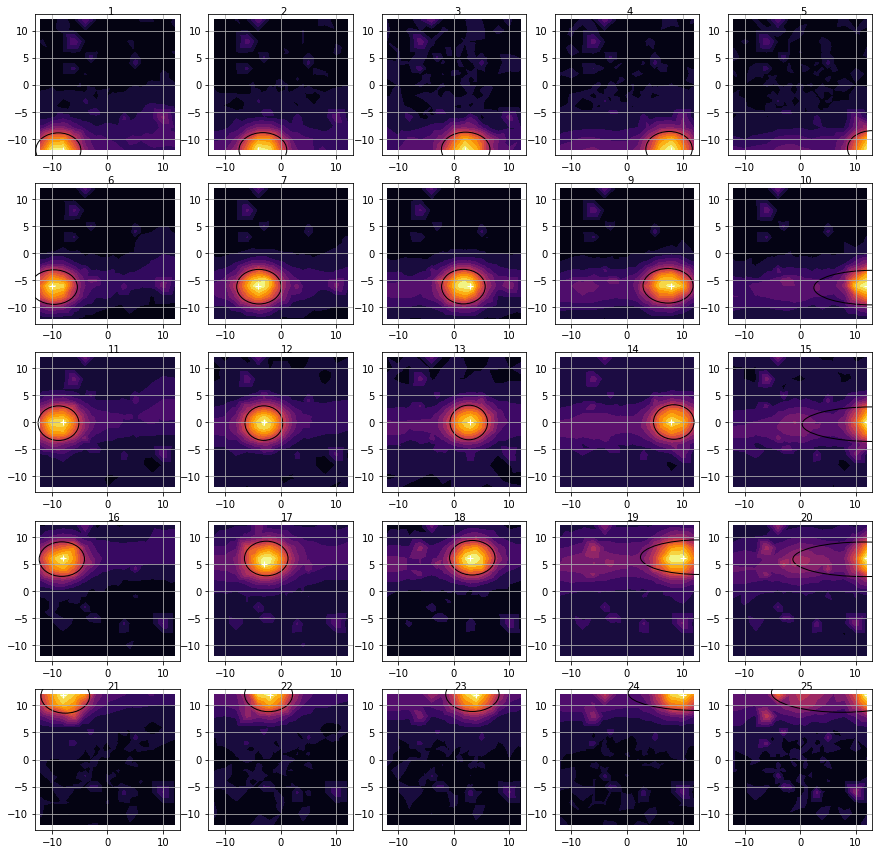

In [3]:
from fifipy.kvector import fitSource

rootdir = '/home/dario/Python/Fifilab/KVectorData/'
xcen,ycen,xsig, ysig = fitSource(rootdir+'R_105.fits', 2)

In [5]:
for i,(x,y,xs,ys) in enumerate(zip(xcen,ycen,xsig,ysig)):
    print(i+1,x,y,xs,ys)

1 -8.849898102129114 -12.107095411762488 0.13510958953909366 0.3387708285438975
2 -3.20348551581262 -12.059211468870785 0.08933463080584574 0.22457611790620402
3 2.1352665144239324 -11.973906140709136 0.11026611516529572 0.25638702379779
4 7.5787064738381495 -11.866714452132548 0.11205655833832398 0.25582674747978257
5 12.999999852072076 -11.782741357219422 4.100283203592518 0.35811345298928804
6 -9.663038537797668 -6.2300302751835295 0.16616953135651877 0.08439006715745617
7 -3.909449485306757 -6.15696815574076 0.06840425713425735 0.05643681050338613
8 1.7218375520239917 -6.149791199154543 0.061490649701753566 0.05977117356130541
9 7.396428291391167 -5.990176394410944 0.1420867674115488 0.09415952979202011
10 13.0 -6.326926473342233 None None
11 -8.827478583838012 -0.20178170582574495 0.1048452938460415 0.07834680472732267
12 -3.025870110302492 -0.18352861100913032 0.06636719529671987 0.05542747693036028
13 2.695178638547217 -0.07161602952097823 0.08228828884232728 0.07140266161799269